
PROCESSING COMPLAINTS DATA
Total Complaints: 1747
   urgency                                               text  \
0     high  I'm having an issue with the {product_purchase...   
1     high  I'm having an issue with the {product_purchase...   
2      low  I'm facing a problem with my {product_purchase...   
8      low  I'm having an issue with the {product_purchase...   
12     low  I'm having an issue with the {product_purchase...   

                                         Cleaned_Text  
0   im issue productpurchased please assist billin...  
1   im issue productpurchased please assist need c...  
2   im facing problem productpurchased productpurc...  
8   im issue productpurchased please assist thank ...  
12  im issue productpurchased please assist cqw di...  

PROCESSING REQUESTS DATA
Total Requests: 6722
  urgency                                               text  \
3     low  I'm having an issue with the {product_purchase...   
4     low  I'm having an issue with the {produc

C:\Users\buddh\AppData\Local\Temp\ipykernel_2376\4063763094.py:194: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='num_characters', data=df_final, palette='Set2')


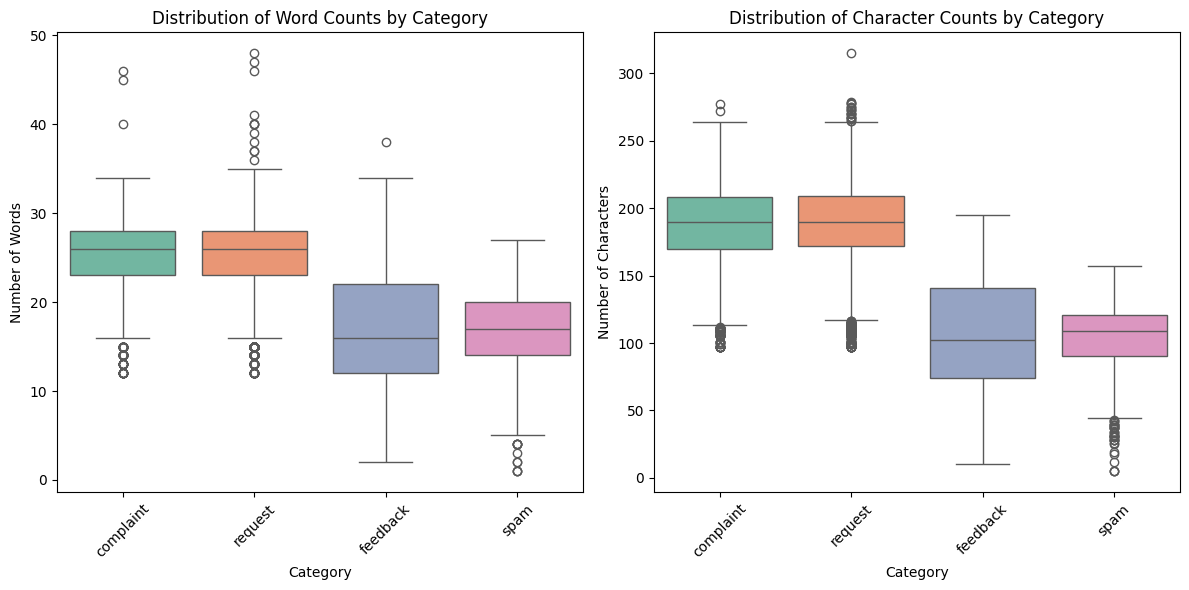

C:\Users\buddh\AppData\Local\Temp\ipykernel_2376\4063763094.py:207: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='num_words', data=df_final[df_final['num_words'] < 500], palette='Set2')


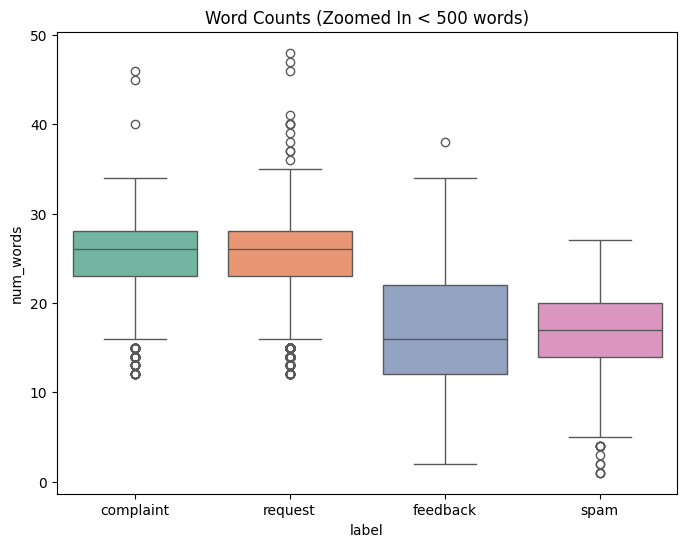


SAVING FINAL DATASET
Dataset successfully saved to 'final_processed_data.csv'
                                                text   category urgency  \
0  I'm having an issue with the {product_purchase...  complaint    high   
1  I've forgotten my password for my {product_pur...    request    high   
2  A game that I just keep going back to. You bas...   feedback     low   
3  From next month get upto 50% More Calls 4 Ur s...       spam     low   
4  I'm having trouble connecting my {product_purc...  complaint     low   

                                        Cleaned_Text      label  \
0  im issue productpurchased please assist produc...  complaint   
1  ive forgotten password productpurchased accoun...    request   
2  game keep going back basically set let ride al...   feedback   
3  next month get upto 50 call 4 ur standard netw...       spam   
4  im trouble connecting productpurchased home wi...  complaint   

   num_characters  num_words  num_sentences  
0             207    

In [3]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_email(text):
    text = str(text).lower()
    text = re.sub(r'\S+@\S+', "", text) 
    text = re.sub(r"http\S+|www\S+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    words = text.split()
    processed_words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(processed_words)

# LOAD DATASETS

df_support = pd.read_csv('customer_support_tickets.csv')
df_spam = pd.read_csv('mail_data.csv')
df_feedback = pd.read_csv('amazon.csv')

# PREPARE SUPPORT DATA (Splitting into Complaints & Requests)

df_support['text'] = df_support['Ticket Description']
df_support['category'] = df_support['Ticket Type'].map({ 
    'Technical issue': 'complaint', 
    'Billing inquiry': 'request', 
    'Product inquiry': 'request', 
    'Cancellation request': 'request', 
    'Refund request': 'request' })

df_support['urgency'] = df_support['Ticket Priority'].map({ 'Critical': 'high', 'High': 'high', 'Medium': 'medium', 'Low': 'low' })
df_support = df_support[['text', 'category', 'urgency']].dropna()

df_support['Cleaned_Text'] = df_support['text'].apply(clean_email)


# 1. PROCESS & PRINT COMPLAINTS

print("\n" + "="*50)
print("PROCESSING COMPLAINTS DATA")
print("="*50)

df_complaints = df_support[df_support['category'] == 'complaint']
print(f"Total Complaints: {len(df_complaints)}")
print(df_complaints[['urgency', 'text', 'Cleaned_Text']].head())



# 2. PROCESS & PRINT REQUESTS

print("\n" + "="*50)
print("PROCESSING REQUESTS DATA")
print("="*50)

df_requests = df_support[df_support['category'] == 'request']
print(f"Total Requests: {len(df_requests)}")
print(df_requests[['urgency', 'text', 'Cleaned_Text']].head())


# 3. PROCESS & PRINT SPAM DATA 

print("\n" + "="*50)
print("PROCESSING SPAM DATA")
print("="*50)

df_spam = df_spam[df_spam['Category'] == 'spam']
df_spam['text'] = df_spam['Message']
df_spam['category'] = 'spam'
df_spam['urgency'] = 'low'
df_spam = df_spam[['text', 'category', 'urgency']]

print("Cleaning Spam Data...")
df_spam['Cleaned_Text'] = df_spam['text'].apply(clean_email)
print(df_spam[['urgency', 'text', 'Cleaned_Text']].head())


#  4. PROCESS & PRINT FEEDBACK DATA 

print("\n" + "="*50)
print("PROCESSING FEEDBACK DATA")
print("="*50)

df_feedback = df_feedback[df_feedback['label'] == 1]
df_feedback['text'] = df_feedback['Text']
df_feedback['category'] = 'feedback'
df_feedback['urgency'] = 'low'
df_feedback = df_feedback[['text', 'category', 'urgency']]
df_feedback = df_feedback.sample(n=min(2000, len(df_feedback)), random_state= 42 )

print("Cleaning Feedback Data...")
df_feedback['Cleaned_Text'] = df_feedback['text'].apply(clean_email)
print(df_feedback[['urgency', 'text', 'Cleaned_Text']].head())


# 5. MERGE & TRAIN

print("\n" + "="*50)
print("MERGING AND TRAINING MODEL")
print("="*50)

# Merge all 4 parts
df_final = pd.concat([df_complaints, df_requests, df_spam, df_feedback], ignore_index=True)
df_final = df_final.sample(frac=1).reset_index(drop=True)
df_final['Cleaned_Text'] = df_final['text'].apply(clean_email)
print(df_final[['category', 'urgency', 'text', 'Cleaned_Text']].head())

# Vectorize
vectorizer = TfidfVectorizer(max_features=5000)
x = vectorizer.fit_transform(df_final['Cleaned_Text'])

# Map Categories
y = df_final['category'].map({'spam': 0, 'complaint': 1, 'request': 2, 'feedback': 3})

# Split & Train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state= 3 )

model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)

# ACCURACY
print("\n" + "="*50)
print("ACCURACY")
print("="*50)

print("Accuracy : ", accuracy_score(y_test, model.predict(x_test)))


# 6. STATISTICS & VISUALIZATIONS
print("\n" + "="*50)
print("STATISTICS & VISUALIZATIONS")
print("="*50)

# Ensure label column exists
if 'Category' in df_final.columns:
    df_final['label'] = df_final['Category']
elif 'category' in df_final.columns:
    df_final['label'] = df_final['category']

# Ensure text column is string
if 'Cleaned_Message' in df_final.columns:
    text_col = 'Cleaned_Message'
elif 'Cleaned_Text' in df_final.columns:
    text_col = 'Cleaned_Text'
else:
    text_col = 'text'

print(f"Using column '{text_col}' for statistics...")
df_final[text_col] = df_final[text_col].astype(str)

# RE-CALCULATE FEATURES 
# Do this again to make sure the columns exist for the print statement
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

df_final['num_characters'] = df_final[text_col].apply(len)
df_final['num_words'] = df_final[text_col].apply(lambda x: len(x.split()))
df_final['num_sentences'] = df_final[text_col].apply(lambda x: len(nltk.sent_tokenize(x)))

# 4. PRINT STATISTICS

print("\n--- Statistics by Category ---")
print(df_final.groupby('label')[['num_characters', 'num_words', 'num_sentences']].describe())


#  PLOT BOXPLOTS

plt.figure(figsize=(12, 6))


# Plot 1: Number of Words
plt.subplot(1, 2, 1)
sns.boxplot(x='label', y='num_words', hue='label', legend=False, data=df_final, palette='Set2')
plt.title('Distribution of Word Counts by Category')
plt.xlabel('Category')
plt.ylabel('Number of Words')
plt.xticks(rotation=45)

# Plot 2: Number of Characters
plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='num_characters', data=df_final, palette='Set2')
plt.title('Distribution of Character Counts by Category')
plt.xlabel('Category')
plt.ylabel('Number of Characters')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# REMOVE OUTLIERS VISUALIZATION

plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='num_words', data=df_final[df_final['num_words'] < 500], palette='Set2')
plt.title('Word Counts (Zoomed In < 500 words)')
plt.show()


# 6. SAVING THE OUTPUT

print("\n" + "="*50)
print("SAVING FINAL DATASET")
print("="*50)

# Saving the merged, cleaned dataframe
filename = "final_processed_data.csv"
df_final.to_csv(filename, index=False)
print(f"Dataset successfully saved to '{filename}'")
print(df_final.head())




